In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import datajoint as dj
# raw data storage
dj.config['external'] = dict(protocol='file',
                              location='/external/')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from staticnet_experiments.models import Model
from neuro_data.static_images.data_schemas import StaticMultiDataset

from staticnet_experiments.configs import NetworkConfig, TrainConfig, ReadoutConfig, ShifterConfig, DataConfig, CoreConfig, ModulatorConfig
from staticnet_experiments.models import Model
neurodata_static = dj.create_virtual_module('neurodata_static', 'neurodata_static')

Connecting donnie@10.28.0.34:3306


In [3]:
# Color MEI scans
target_scans = [
    dict(animal_id = 22845, session = 7, scan_idx = 5),
    dict(animal_id = 22845, session = 10, scan_idx = 5),
    dict(animal_id = 22086, session = 2, scan_idx = 3),
    dict(animal_id = 22904, session = 4, scan_idx = 2)]


In [4]:
# group_id = 78~81
target_group_id = (StaticMultiDataset.Member & target_scans) & 'group_id < 82' & 'group_id > 77' 

target_groupd_id_list = [78, 79, 80, 81]

In [5]:

# CoreConfig.GaussianLaplace Params
gauss_bias = 0.0
gauss_sigma = 0.5
input_kern = 15
hidden_kern = 7

core_restriction = dict(gauss_bias = 0.0, gauss_sigma = 0.5, input_kern = 15, hidden_kern = 7)

# configs TrainConfig.Default
batch_size = 60

# ReadoutConfig.SpatialTransformerPyramid2d() restrictions
downsample = False

# DataConfig.CorrectedAreaLayer() restriction
stimulus_type = 'stimulus.ColorFrameProjector'
exclude = ''
layer = 'L2/3'
brain_area = 'V1'
normalize_per_image = 'False'

# These are a bunch of configuration for different parts of 

# LINEAR MODEL
linear_CoreConfig_hash = (CoreConfig.StackedLinearGaussianLaplace() & 
                           dict(gauss_bias = gauss_bias,
                                gauss_sigma = gauss_sigma, 
                                input_kern = input_kern, 
                                hidden_kern = hidden_kern))

# NON-LINEAR MODEL
nonlinear_CoreConfig_hash = (CoreConfig.GaussianLaplace() & 
                           dict(gauss_bias = gauss_bias,
                                gauss_sigma = gauss_sigma, 
                                input_kern = input_kern, 
                                hidden_kern = hidden_kern))

TrainConfig_hash = (TrainConfig.Default & dict(batch_size = batch_size))

ReadoutConfig_hash = (ReadoutConfig.SpatialTransformerPyramid2d() & dict(downsample = downsample)) 

DataConfig_hash = (DataConfig.CorrectedAreaLayer() & 
                   dict(stimulus_type = stimulus_type, 
                        exclude = exclude, 
                        layer = layer, 
                        brain_area = brain_area, 
                        normalize_per_image=normalize_per_image))

nonlinear_model_config_restrictions = (NetworkConfig.CorePlusReadout() 
                    & nonlinear_CoreConfig_hash
                    & TrainConfig_hash
                    & ReadoutConfig_hash
                    & ShifterConfig.MLP() 
                    & ModulatorConfig.MLP() 
                    & DataConfig_hash)

linear_model_config_restrictions = (NetworkConfig.CorePlusReadout() 
                    & linear_CoreConfig_hash
                    & TrainConfig_hash
                    & ReadoutConfig_hash
                    & ShifterConfig.MLP() 
                    & ModulatorConfig.MLP() 
                    & DataConfig_hash)


In [6]:
# only retain the ones with best val_corr
nonlinear_best_cases = []

for _id in target_groupd_id_list:
    # seed has to be 1009 for UnitRanking Table later
    _case = ((((Model() & nonlinear_model_config_restrictions) & target_group_id)) 
             & 'group_id = {}'.format(_id) & 'seed = 1009').fetch('KEY', order_by='val_corr DESC')[0]
    nonlinear_best_cases.append(_case)

nonlinear_best_table = (Model & nonlinear_best_cases[0]).proj()

for _case in nonlinear_best_cases:
    nonlinear_best_table += (Model & _case).proj()

    
linear_best_cases = []

for _id in target_groupd_id_list:
    # seed has to be 1009 for UnitRanking Table later
    _case = ((((Model() & linear_model_config_restrictions) & target_group_id)) 
             & 'group_id = {}'.format(_id) & 'seed = 1009').fetch('KEY', order_by='val_corr DESC')[0]
    linear_best_cases.append(_case)

linear_best_table = (Model & linear_best_cases[0]).proj()

for _case in linear_best_cases:
    linear_best_table += (Model & _case).proj()
    

# based on unit ranking, plot top 50 RFs

In [7]:
from staticnet_mei_generation.MEIGenerationResult import MEIGenerationResult
from staticnet_analyses.base import UnitRanking, Dataset
from neuro_data.pipeline_management.spike_triggered_avg_rf import StaticSpikeTriggeredAverageRF

/usr/local/lib/python3.6/dist-packages/staticnet_analyses/multi_mei.py:1651: UserWarning: Use of this table is deprecated. It is kept only for record keeping purpose
  warnings.warn('Use of this table is deprecated. It is kept only for record keeping purpose')


In [8]:
neuron_num = 50

In [9]:
nonlinear_best_cases = nonlinear_best_table.fetch(as_dict=True)

In [10]:
def append_zero_channel_dim(img):
    """
    Adds an empty channel to the image and tranpose it from CxHxW to HxWxC

    Args:
        img (ndarray): img in the format of CxHxW

    Returns:
        img (ndarray): img with the additional channel added and transpose to have the format of HxWxC
    """
    return np.append((img), np.zeros(shape=(1, 36, 64)), axis=0).transpose(1, 2, 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

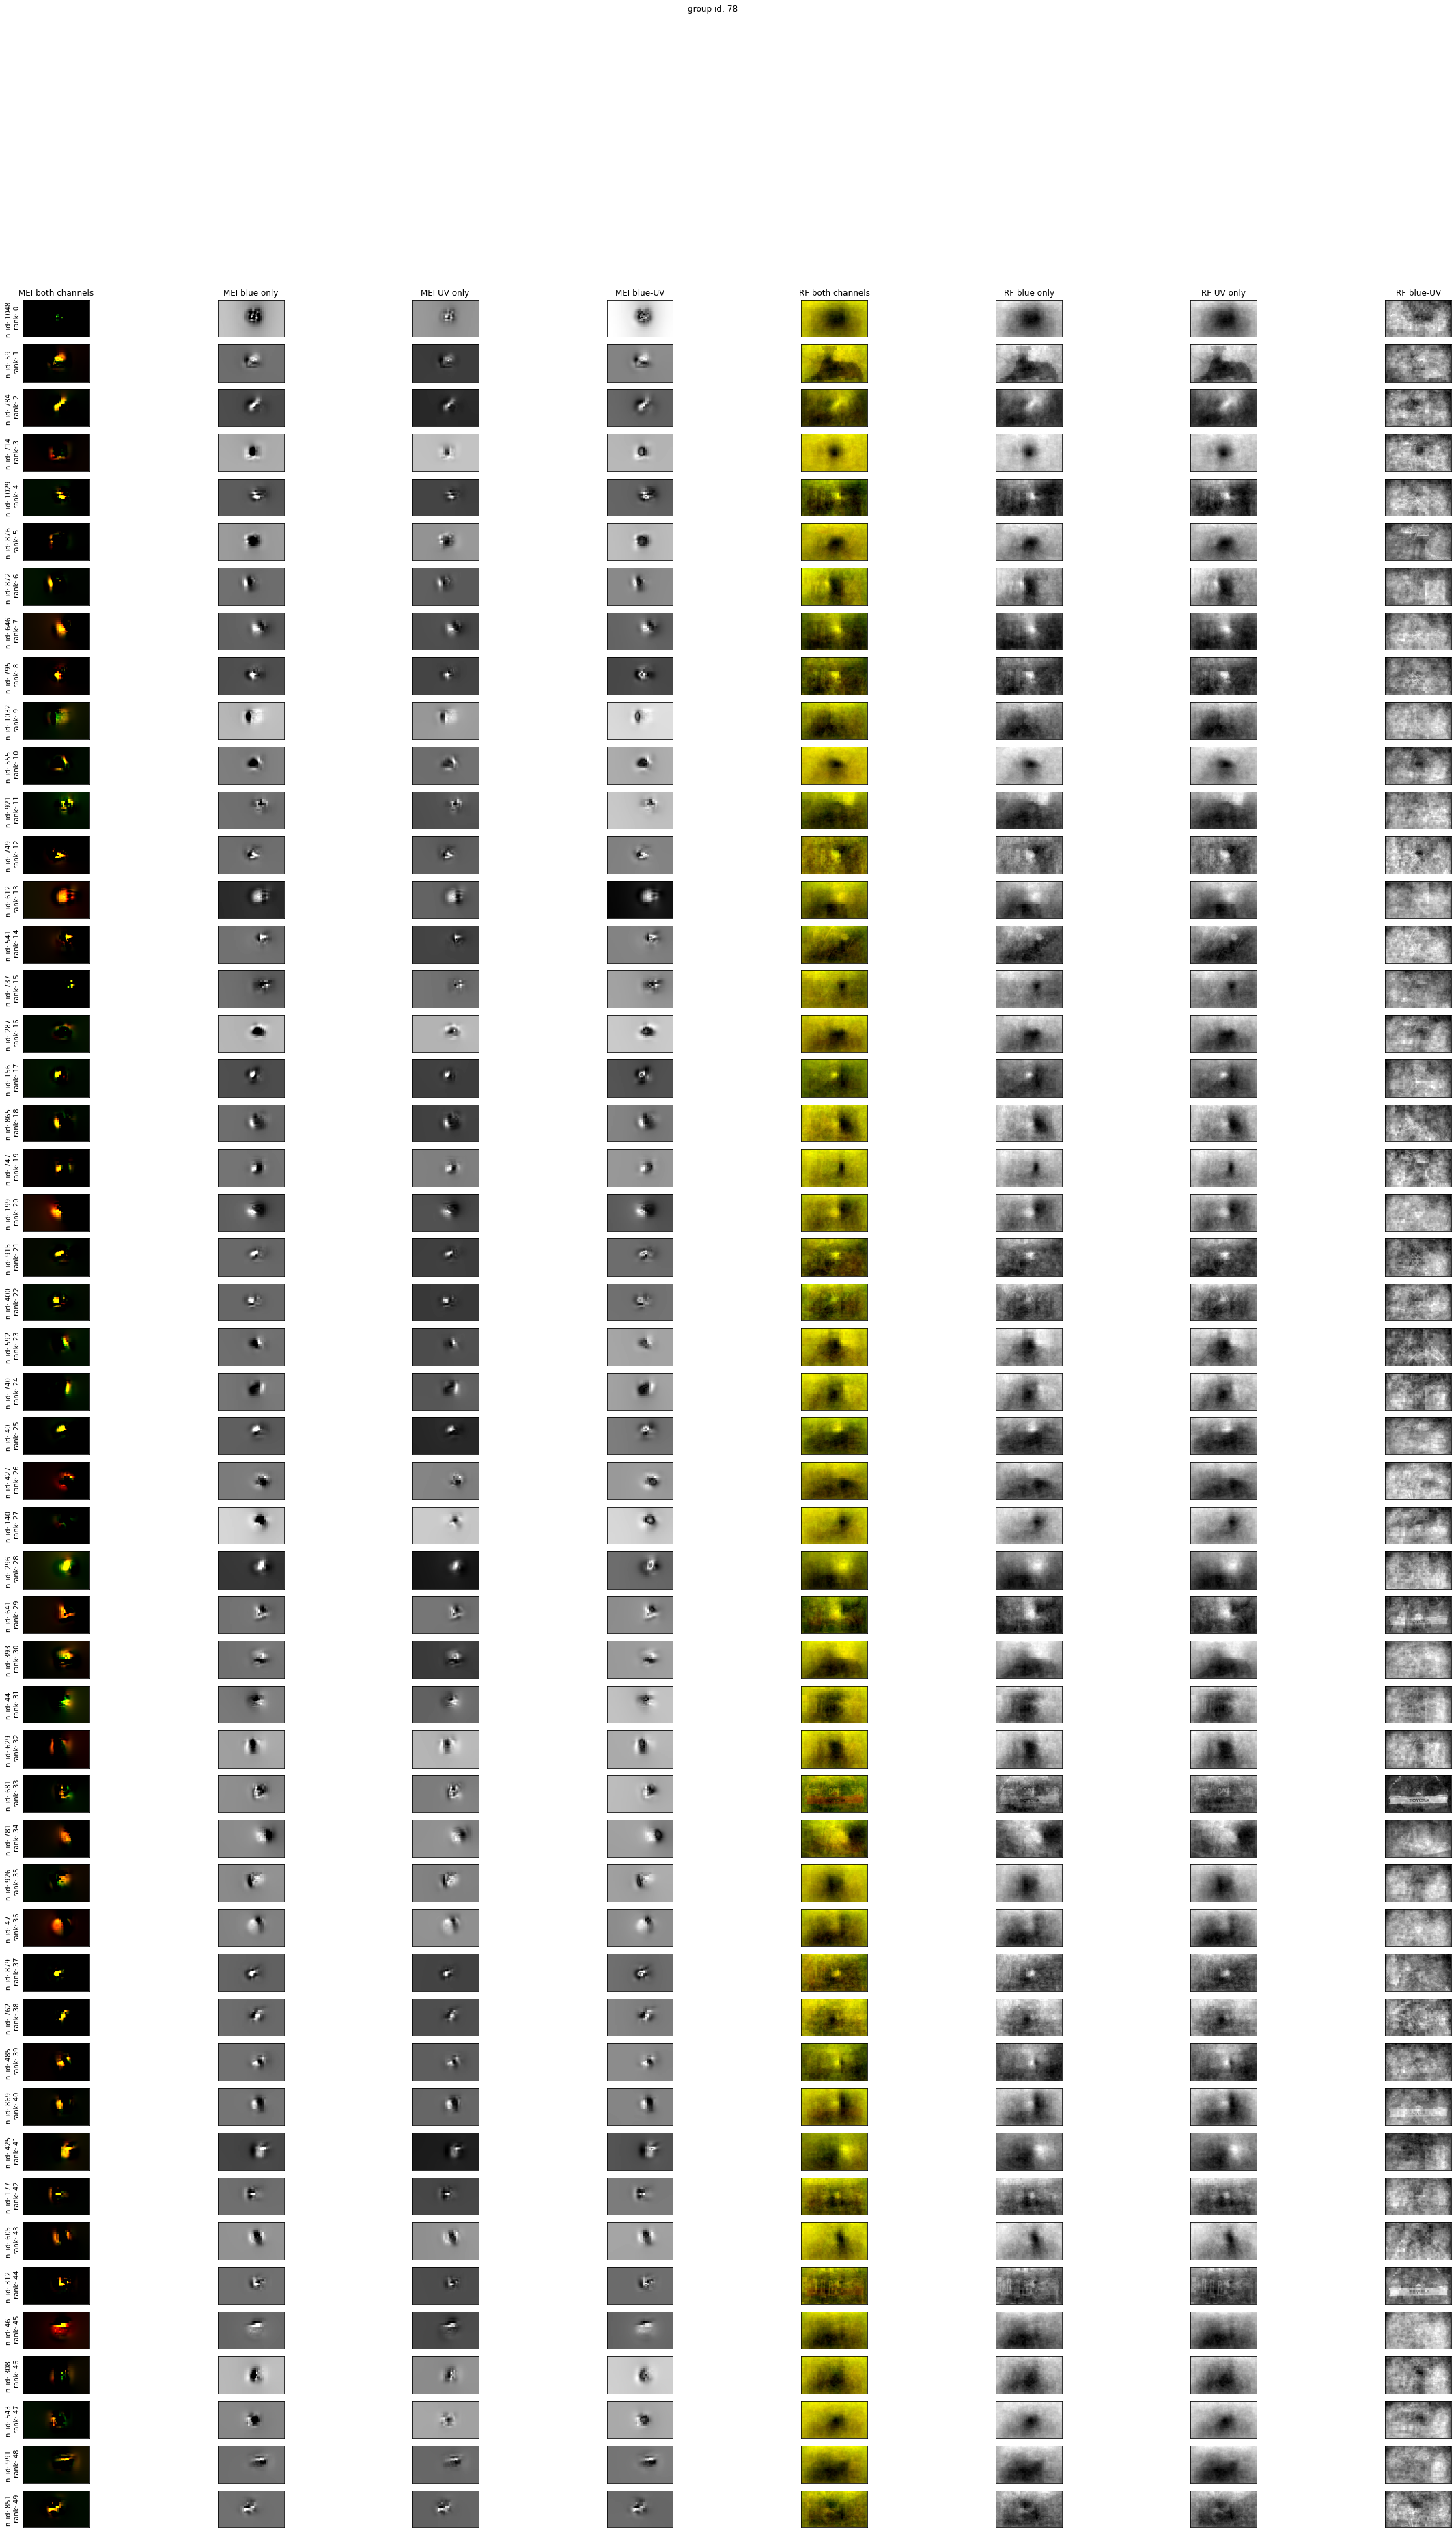

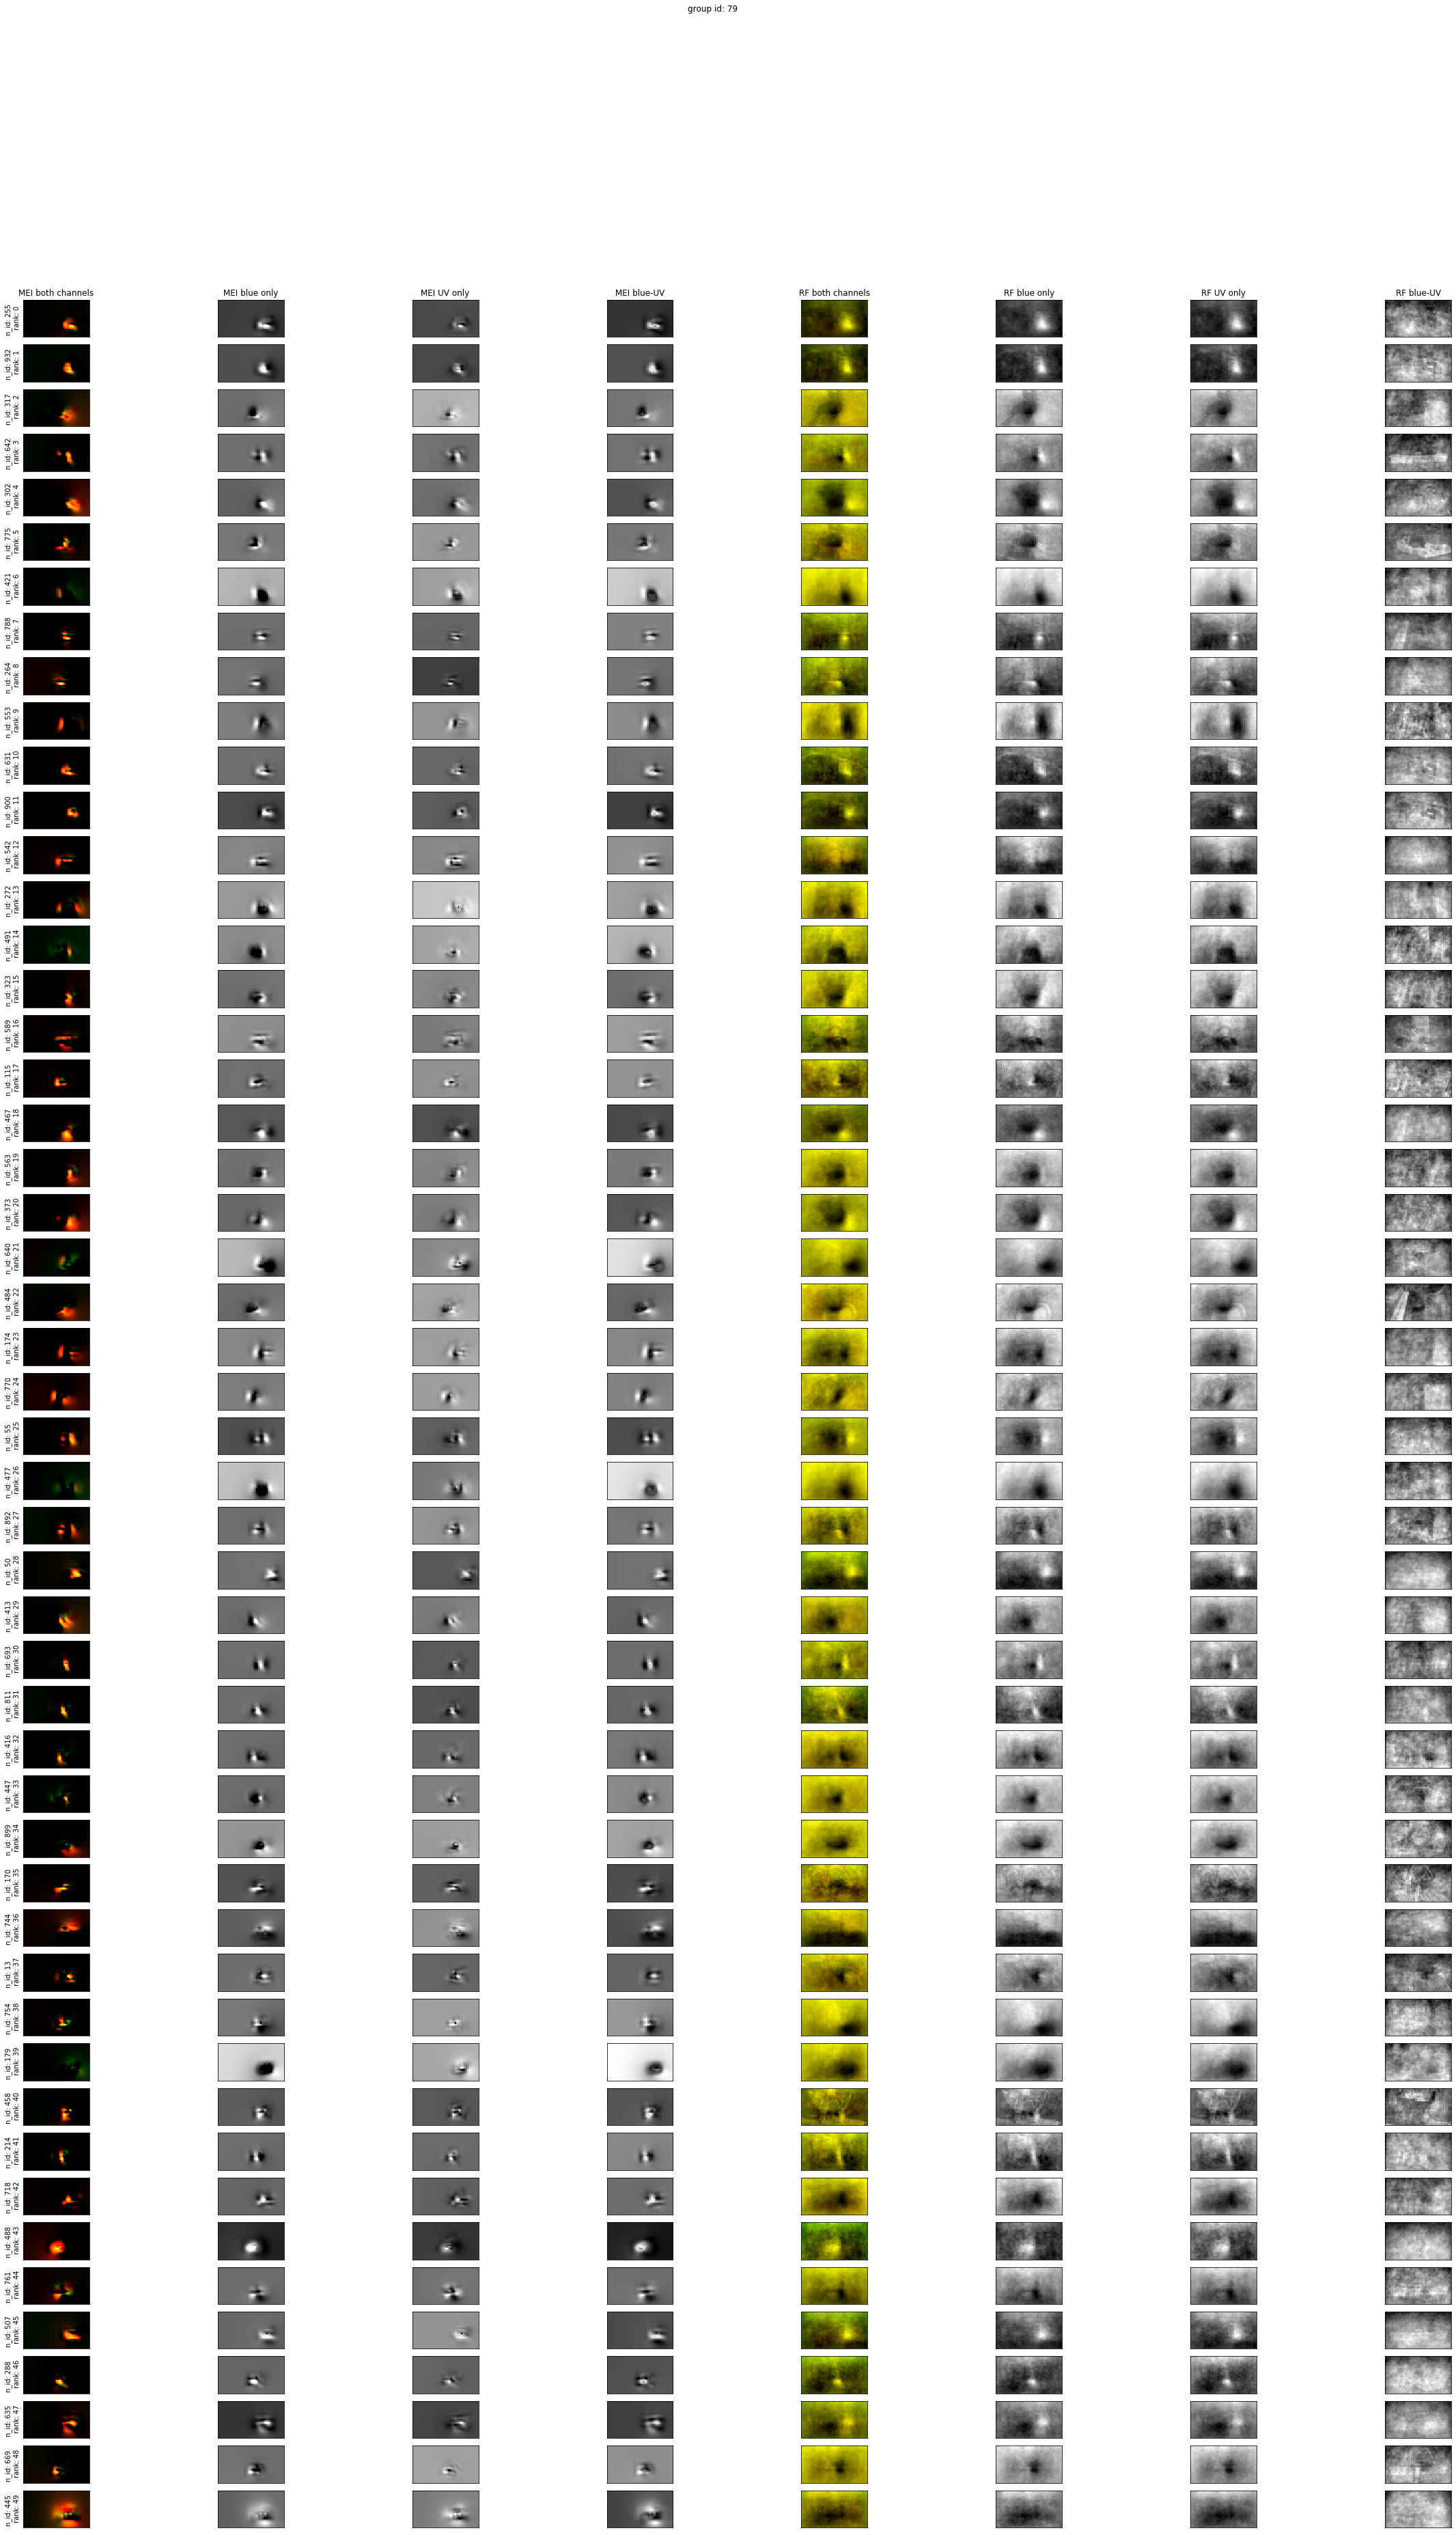

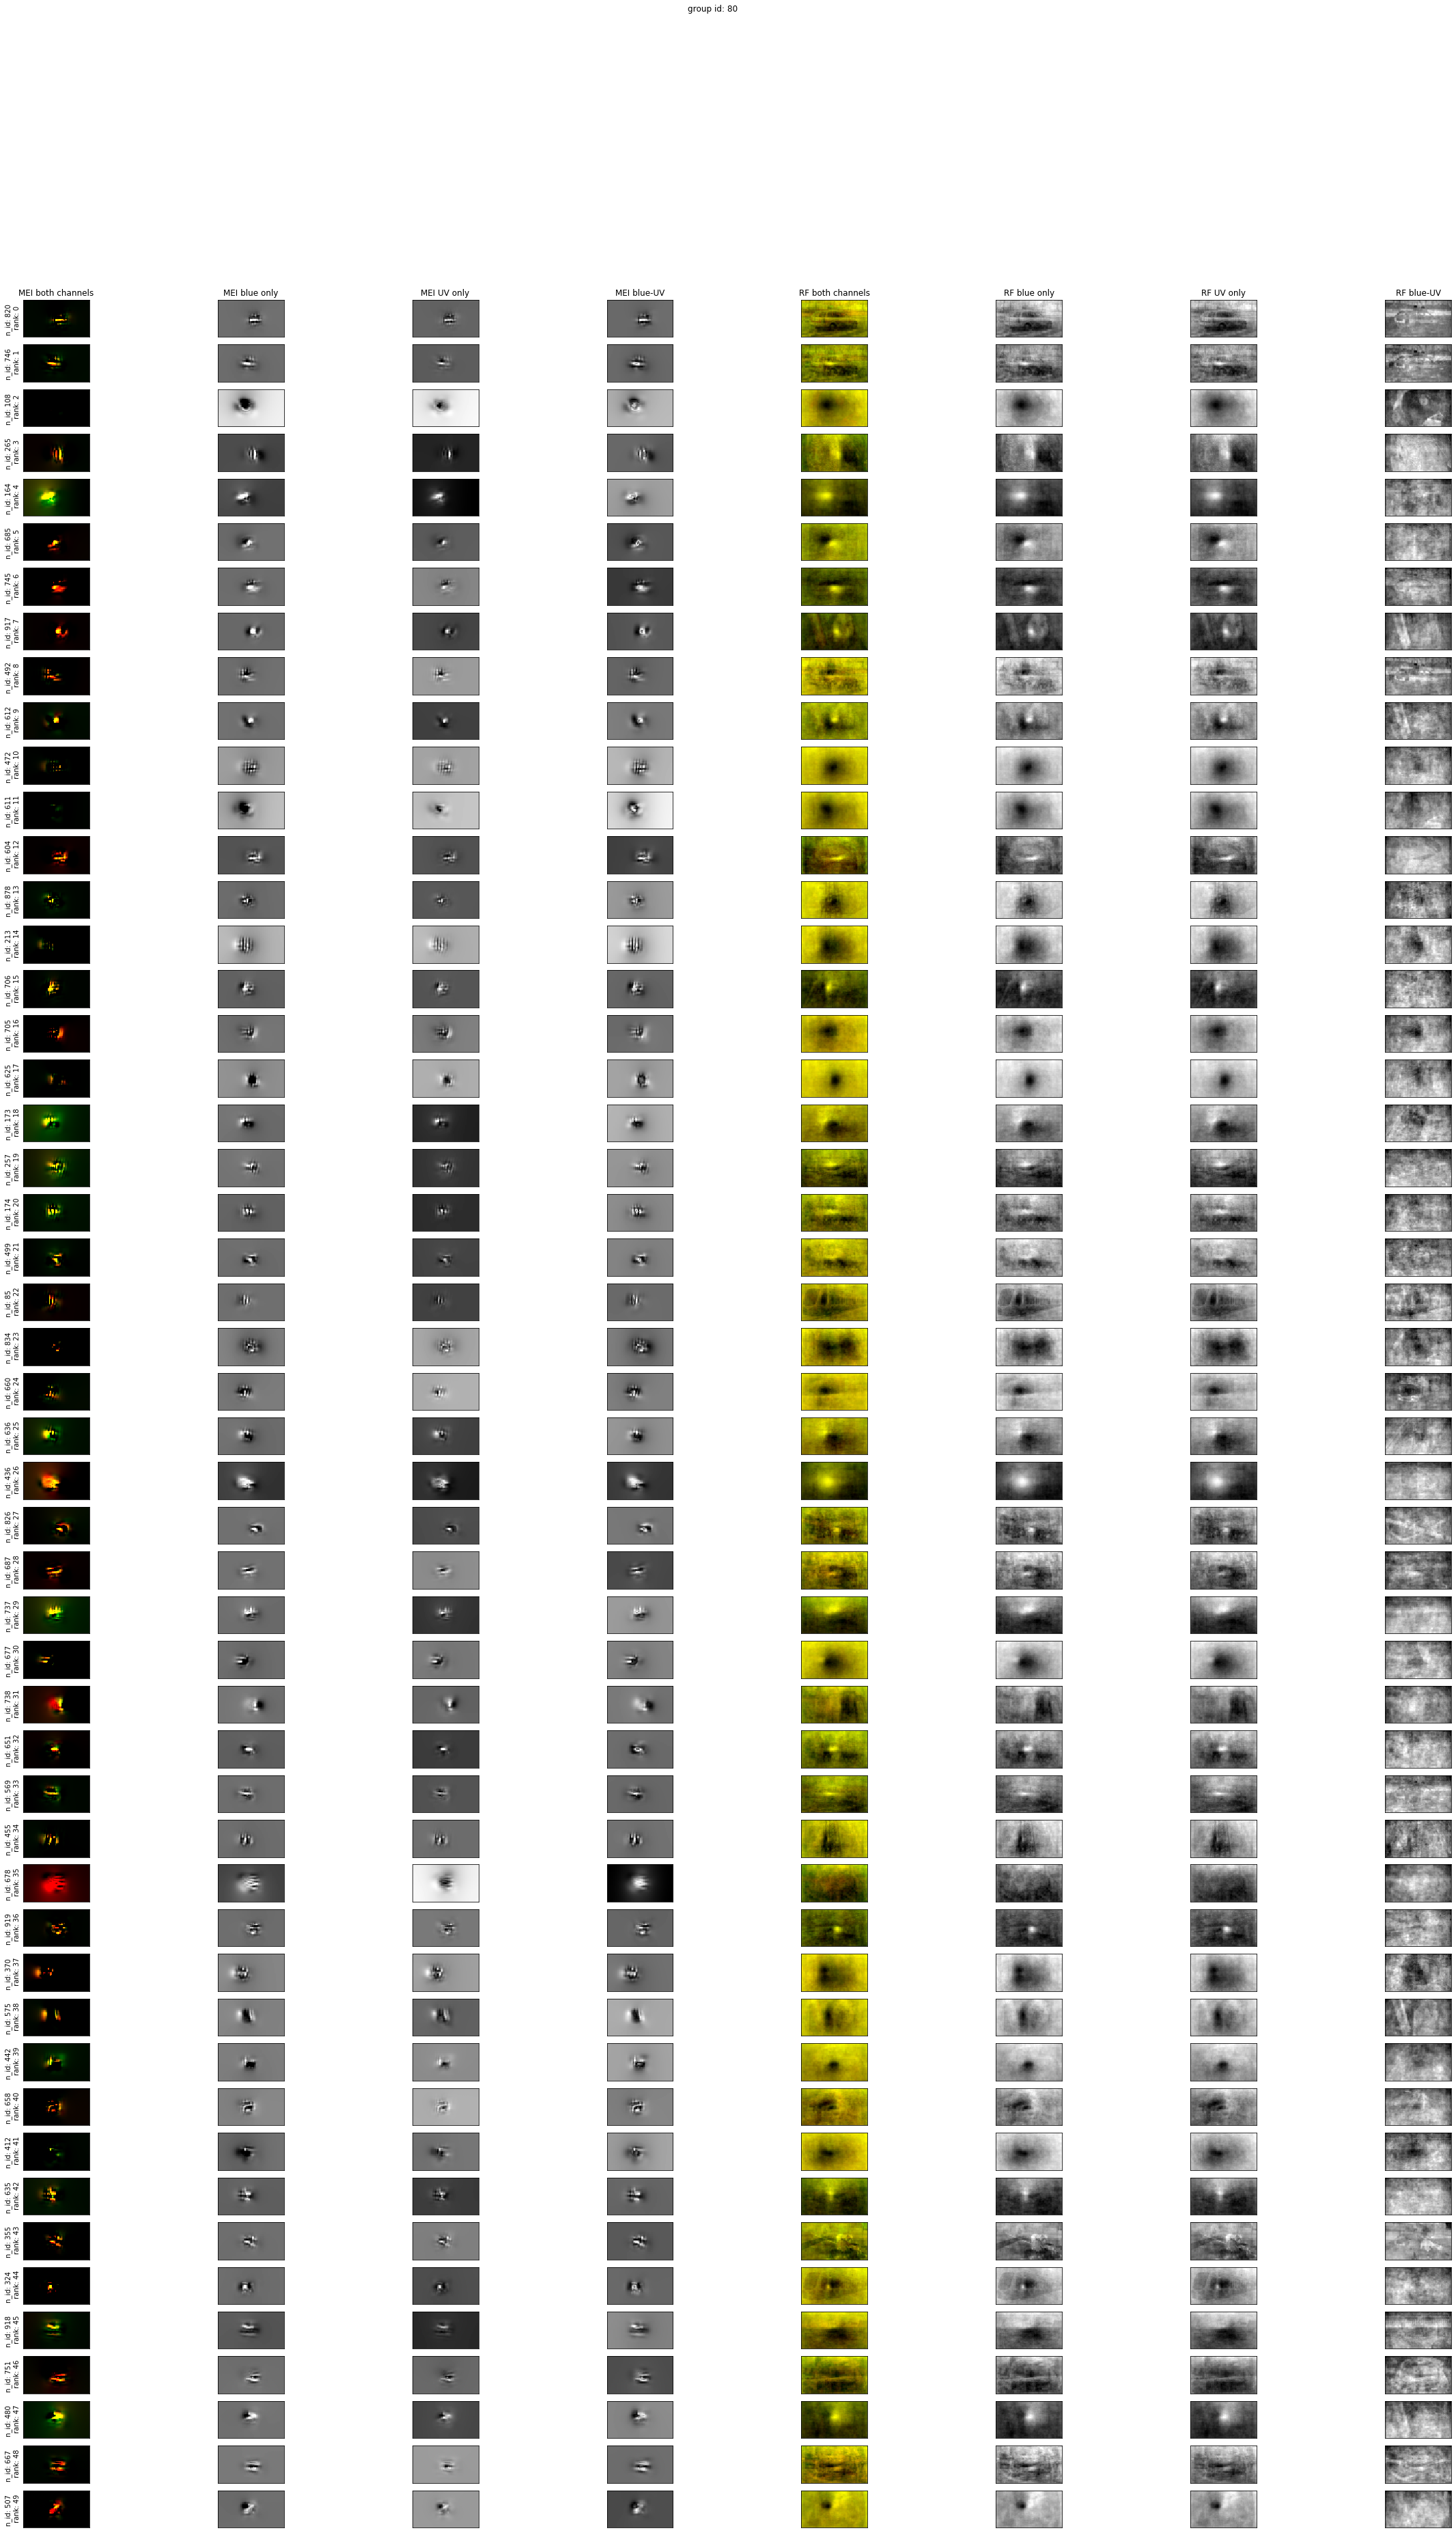

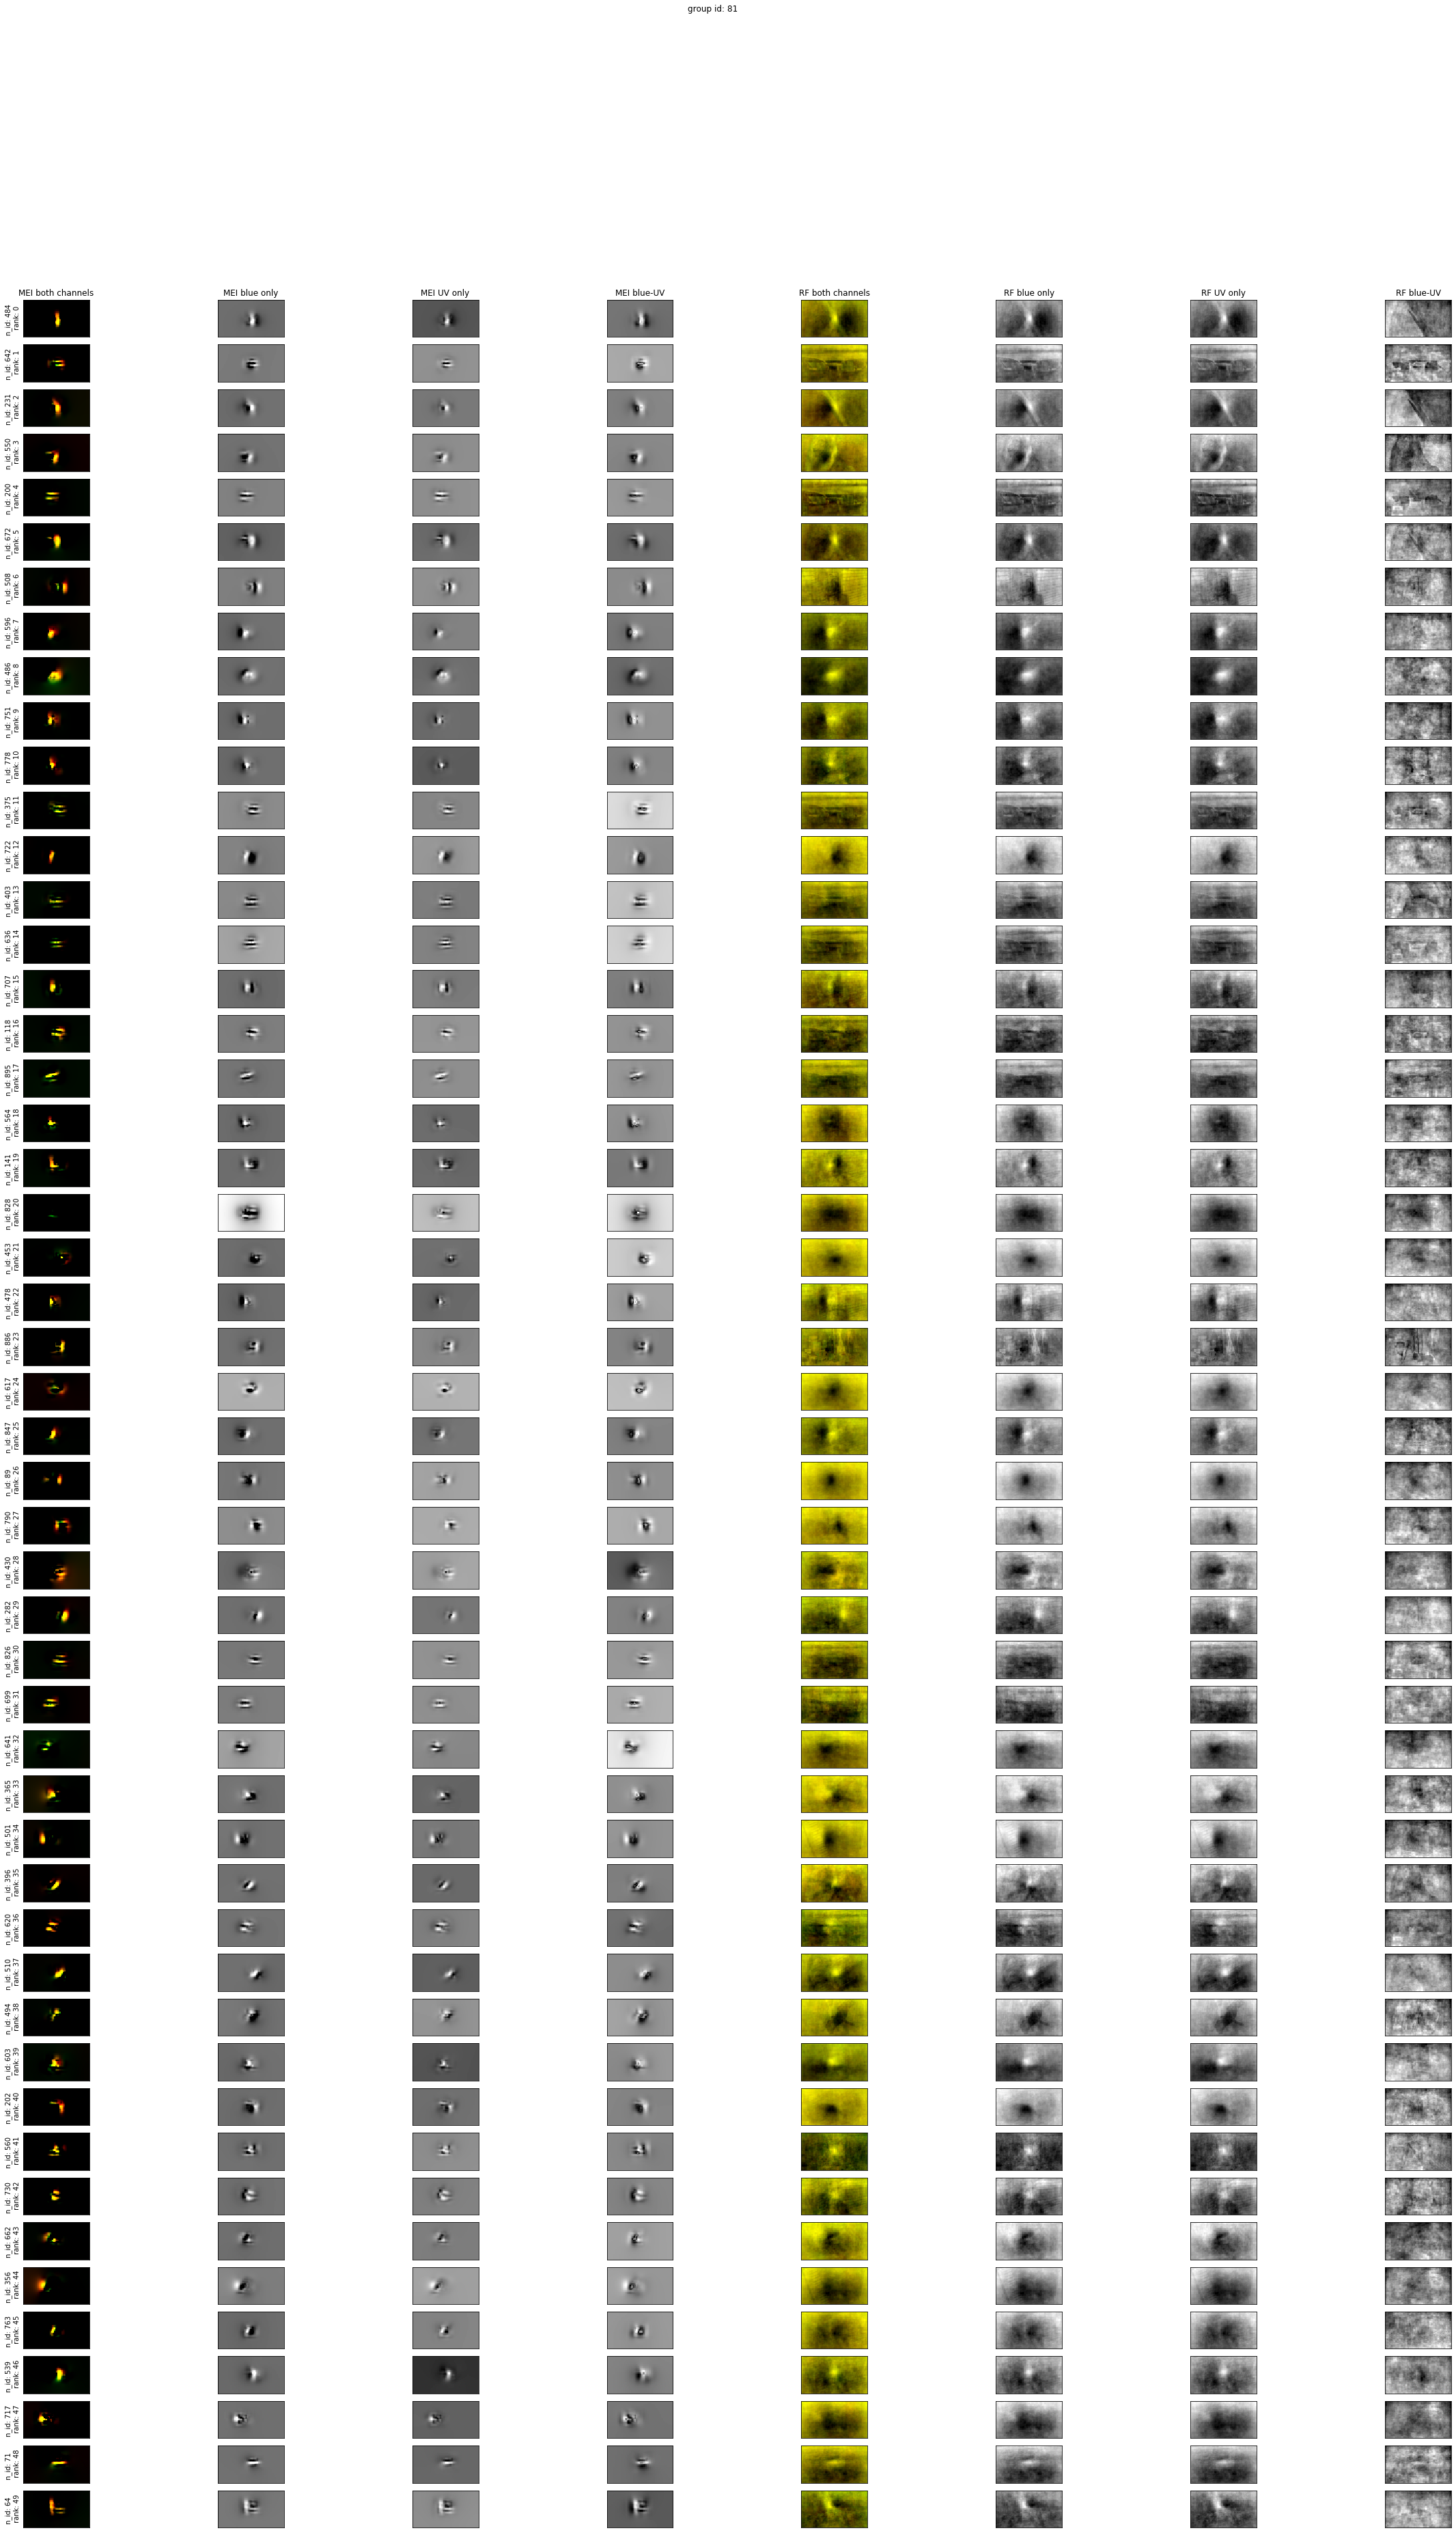

In [131]:
for _case in nonlinear_best_cases:
    
    # obtain neuron_id based on rank
    MEI_result = MEIGenerationResult * UnitRanking.Unit & _case & 'rank < {}'.format(neuron_num)
    MEI_list = MEI_result.fetch('mei', order_by='rank ASC')
    neuron_table = dj.U('group_id','data_hash','neuron_id','rank') & MEI_result
    
    # find matching unit_id from neuron_id using Dataset.Unit table and obtain sta_rf
    # confirm they are the same
    sta_table = (StaticSpikeTriggeredAverageRF.Unit * (Dataset.Unit * neuron_table))
    assert len(sta_table) == neuron_num 
    
    neuron_ids, unit_ids, ranks, sta_rfs = (sta_table).fetch('neuron_id',
                                                             'unit_id',
                                                             'rank',
                                                             'sta_rf',
                                                             order_by='rank ASC')
    
    #plot
    fig, ax_list = plt.subplots(neuron_num, 8, figsize=(40,60))
    
    for rank, neuron_id, MEI, sta_rf, ax in zip(ranks, neuron_ids, MEI_list, sta_rfs, ax_list):
        
        MEI_full = append_zero_channel_dim(MEI)
        RF_full = append_zero_channel_dim(sta_rf.transpose(2,0,1))

        RF_full[:,:,0] = (RF_full[:,:,0] - RF_full[:,:,0].min())/(RF_full[:,:,0].max() - RF_full[:,:,0].min())
        RF_full[:,:,1] = (RF_full[:,:,1] - RF_full[:,:,1].min())/(RF_full[:,:,1].max() - RF_full[:,:,1].min())

        if rank == 0:
            # Full MEI
            ax[0].imshow(MEI_full)
            ax[0].set_ylabel('n_id: {} \n rank: {}'.format(neuron_id, rank))
            ax[0].set_title('MEI both channels')
            ax[0].get_xaxis().set_ticks([])
            ax[0].get_yaxis().set_ticks([])

            # blue MEI
            ax[1].imshow(MEI[0,:,:], cmap='gray')
            ax[1].set_title('MEI blue only')
            ax[1].get_xaxis().set_ticks([])
            ax[1].get_yaxis().set_ticks([])

            # UV MEI
            ax[2].imshow(MEI[1,:,:], cmap='gray')
            ax[2].set_title('MEI UV only')
            ax[2].get_xaxis().set_ticks([])
            ax[2].get_yaxis().set_ticks([])

            # subtraction MEI
            ax[3].imshow(MEI[0,:,:]-MEI[1,:,:], cmap='gray')
            ax[3].set_title('MEI blue-UV')
            ax[3].get_xaxis().set_ticks([])
            ax[3].get_yaxis().set_ticks([])


            #################################################

            # Full RF
            ax[4].imshow(RF_full)
            ax[4].set_title('RF both channels')
            ax[4].get_xaxis().set_ticks([])
            ax[4].get_yaxis().set_ticks([])

            # blue rf
            ax[5].imshow(RF_full[:,:,0], cmap='gray')
            ax[5].set_title('RF blue only')
            ax[5].get_xaxis().set_ticks([])
            ax[5].get_yaxis().set_ticks([])

            # UV rf
            ax[6].imshow(RF_full[:,:,1], cmap='gray')
            ax[6].set_title('RF UV only')
            ax[6].get_xaxis().set_ticks([])
            ax[6].get_yaxis().set_ticks([])

            # subtraction rf
            ax[7].imshow(RF_full[:,:,0]-RF_full[:,:,1], cmap='gray')
            ax[7].set_title('RF blue-UV')
            ax[7].get_xaxis().set_ticks([])
            ax[7].get_yaxis().set_ticks([])
        
        else:
            # Full MEI
            ax[0].imshow(MEI_full)
            ax[0].set_ylabel('n_id: {} \n rank: {}'.format(neuron_id, rank))
            ax[0].get_xaxis().set_ticks([])
            ax[0].get_yaxis().set_ticks([])

            # blue MEI
            ax[1].imshow(MEI[0,:,:], cmap='gray')
            ax[1].get_xaxis().set_ticks([])
            ax[1].get_yaxis().set_ticks([])

            # UV MEI
            ax[2].imshow(MEI[1,:,:], cmap='gray')
            ax[2].get_xaxis().set_ticks([])
            ax[2].get_yaxis().set_ticks([])

            # subtraction MEI
            ax[3].imshow(MEI[0,:,:]-MEI[1,:,:], cmap='gray')
            ax[3].get_xaxis().set_ticks([])
            ax[3].get_yaxis().set_ticks([])


            #################################################

            # Full RF
            ax[4].imshow(RF_full)
            ax[4].get_xaxis().set_ticks([])
            ax[4].get_yaxis().set_ticks([])

            # blue rf
            ax[5].imshow(RF_full[:,:,0], cmap='gray')
            ax[5].get_xaxis().set_ticks([])
            ax[5].get_yaxis().set_ticks([])

            # UV rf
            ax[6].imshow(RF_full[:,:,1], cmap='gray')
            ax[6].get_xaxis().set_ticks([])
            ax[6].get_yaxis().set_ticks([])

            # subtraction rf
            ax[7].imshow(RF_full[:,:,0]-RF_full[:,:,1], cmap='gray')
            ax[7].get_xaxis().set_ticks([])
            ax[7].get_yaxis().set_ticks([])
    
    fig.suptitle('group id: {}'.format(_case['group_id']))
    fig.savefig('MEI_vs_RF_group_id_{}.png'.format(_case['group_id']))

In [14]:
for _case in nonlinear_best_cases:
    
    # obtain neuron_id based on rank
    MEI_result = MEIGenerationResult * UnitRanking.Unit & _case & 'rank < {}'.format(neuron_num)

    MEI_df = pd.DataFrame((MEI_result).fetch(as_dict=True, order_by='rank ASC'))
    MEI_df = MEI_df[['group_id','rank','neuron_id','mei']]
    # find matching unit_id from neuron_id using Dataset.Unit table and obtain sta_rf
    # confirm they are the same
    sta_table = (StaticSpikeTriggeredAverageRF.Unit * (Dataset.Unit * MEI_result))
    assert len(sta_table) == neuron_num 
    
    sta_rfs = sta_table.fetch('sta_rf', order_by='rank ASC')
    
    MEI_df['sta_rf'] = sta_rfs
    
    MEI_df.to_hdf('MEI_rf_gid_{}.h5'.format(_case['group_id']), 'group_id')

    

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:2530: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['mei', 'sta_rf']]

  pytables.to_hdf(path_or_buf, key, self, **kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:2530: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['mei', 'sta_rf']]

  pytables.to_hdf(path_or_buf, key, self, **kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:2530: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['mei', 'sta_rf']]

  pytables.to_hdf(path_or_buf, key, self, **kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/gene